In [1]:
from graphchem.datasets import load_lhv
from sklearn.model_selection import train_test_split

# load LHV data
smiles, lhv = load_lhv()

# create training/testing subsets
smiles_train, smiles_test, lhv_train, lhv_test = train_test_split(smiles, lhv, test_size=0.2, random_state=42)

print(len(smiles_train), len(smiles_test), type(smiles))
print(len(lhv_train), len(lhv_test), type(lhv), lhv.shape, '\n')

for i in range(5):

    print(f'{smiles[i]}\t{lhv[i]}')

310 78 <class 'list'>
310 78 <class 'torch.Tensor'> torch.Size([388, 1]) 

[C-]#[O+]	tensor([10.])
CO	tensor([21.])
C#C	tensor([48.])
C=C	tensor([47.])
C1CO1	tensor([28.])


In [2]:
from graphchem.data import MoleculeGraph, MoleculeDataset
from graphchem.preprocessing import MoleculeEncoder

# construct encoder using training data
encoder = MoleculeEncoder(smiles_train)

# encode training and test data; each element in form (atom attr, bond attr, connectivity)
encoding_train = encoder.encode_many(smiles_train)
encoding_test = encoder.encode_many(smiles_test)

print('\n', encoding_train[0], '\n')

# construct graphs using encoded data
graphs_train = [MoleculeGraph(e[0], e[1], e[2], lhv_train[i]) for i, e in enumerate(encoding_train)]
graphs_test = [MoleculeGraph(e[0], e[1], e[2], lhv_test[i]) for i, e in enumerate(encoding_test)]

# construct datasets for training and testing graphs
ds_train = MoleculeDataset(graphs_train)
ds_test = MoleculeDataset(graphs_test)

print(len(ds_train), len(ds_test))


 (tensor([2, 2, 2, 3, 2], dtype=torch.int32), tensor([2, 2, 2, 2, 2, 3, 3, 3, 3, 2], dtype=torch.int32), tensor([[0, 0, 1, 1, 2, 2, 3, 3, 4, 4],
        [1, 4, 0, 2, 1, 3, 2, 4, 3, 0]])) 

310 78


c:\Users\tjkessler\.conda\envs\graphchem\Lib\site-packages\graphchem-2.1.0-py3.11.egg\graphchem\data\structs.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(target).type(torch.float).reshape(1, len(target))


In [3]:
from graphchem.nn import MoleculeGCN
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

# prepare training set for training
train_loader = DataLoader(ds_train, batch_size=16, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=1, shuffle=False)

atom_vocab_size, bond_vocab_size = encoder.vocab_sizes

# construct untrained model
model = MoleculeGCN(
    atom_vocab_size,                # number of node/atom features per sample
    bond_vocab_size,                # number of edge/bond features per sample
    1,                              # number of target variables/labels per sample
    embedding_dim=128,              # size of atom/bond embedding
    n_messages=3,                   # number of message-passing ops to perform (>= 1)
    n_readout=3,                    # number of post-graph-operation feed-forward layers (>= 1)
    readout_dim=128,                # number of neurons in each readout layer (>= 1)
    dropout=0.0                     # neuron dropout rate [0.0, 1.0]
)

# construct torch optimizer
lr_decay = 1e-8
init_lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)

train_losses = []
test_losses = []

# training loop
model.train()
for epoch in range(400):

    for g in optimizer.param_groups:
        g['lr'] = max(0, init_lr - (epoch * lr_decay))

    train_loss = 0.0
    for batch in train_loader:

        optimizer.zero_grad()
        pred, _, _ = model(batch)
        loss = F.mse_loss(pred, batch.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.detach().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    test_loss = 0.0
    for batch in test_loader:

        pred, _, _ = model(batch)
        target = batch.y
        loss = F.mse_loss(pred, batch.y)
        test_loss += loss.detach().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    if epoch % 5 == 0:
        print(f'{epoch}: {train_loss}')

# done training
model.eval()

0: 26.09936833535471
5: 6.545895836430211
10: 2.851555904265373
15: 1.4007623980122228
20: 1.045286343174596
25: 0.9547821360249673
30: 0.3742928685680513
35: 0.3164090068109574
40: 0.4506806981179022
45: 0.526952322067753
50: 0.41907658346237675
55: 0.39961191954151276
60: 0.15864104513199098
65: 0.2903070022982936
70: 0.12326773289711244
75: 0.1307665632617089
80: 0.15309021184521338
85: 0.0940049579066615
90: 0.09767268367352024
95: 0.1813660035210271
100: 0.15303031206130982
105: 0.06872039177725392
110: 0.23819863161733074
115: 0.17259144263882792
120: 0.08698000398374373
125: 0.04699701008296782
130: 0.07663023664105323
135: 0.06875550304689715
140: 0.08945667195704675
145: 0.0379372184795718
150: 0.17124233784214143
155: 0.04982625813253464
160: 0.04178976805940751
165: 0.04145917181045778
170: 0.050280313962890254
175: 0.08975834870530713
180: 0.08794481581257235
185: 0.05848086851258432
190: 0.061195207459311333
195: 0.04609723437216974
200: 0.42214398134139275
205: 0.06453769

MoleculeGCN(
  (emb_atom): Embedding(63, 128)
  (emb_bond): Embedding(55, 128)
  (atom_conv): GeneralConv(128, 128)
  (bond_conv): EdgeConv(nn=Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
  ))
  (readout): ModuleList(
    (0-2): 3 x Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

<Figure size 640x480 with 0 Axes>

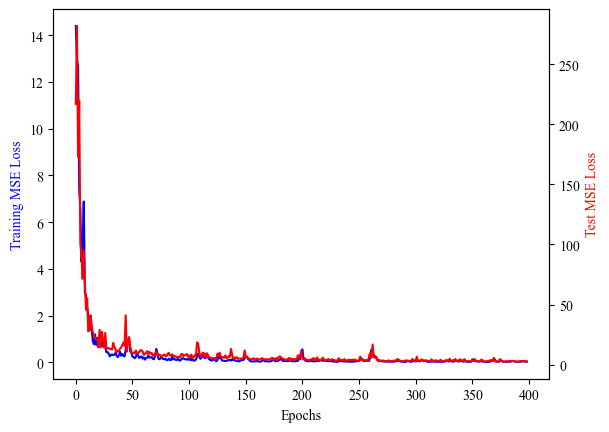

In [4]:
from matplotlib import pyplot as plt

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
fig, ax = plt.subplots()
ax.plot([i for i in range(len(train_losses[1:]))], train_losses[1:], color='blue')
ax.set_xlabel('Epochs')
ax.set_ylabel('Training MSE Loss', color='blue')
ax2 = ax.twinx()
ax2.plot([i for i in range(len(test_losses[1:]))], test_losses[1:], color='red')
ax2.set_ylabel('Test MSE Loss', color='red')
plt.show()

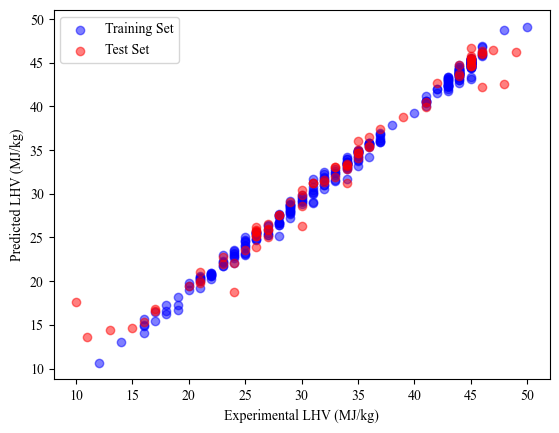

In [5]:
pred_train = [model(mol)[0].detach().numpy() for mol in ds_train]
pred_test = [model(mol)[0].detach().numpy() for mol in ds_test]
exp_train = [mol.y.numpy() for mol in ds_train]
exp_test = [mol.y.numpy() for mol in ds_test]

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.scatter(exp_train, pred_train, color='blue', label='Training Set', alpha=0.5)
plt.scatter(exp_test, pred_test, color='red', label='Test Set', alpha=0.5)
plt.xlabel('Experimental LHV (MJ/kg)')
plt.ylabel('Predicted LHV (MJ/kg)')
plt.legend(loc='upper left')
plt.show()

In [6]:
from sklearn.metrics import median_absolute_error, r2_score

e_test = [e[0] for e in exp_test]
p_test = [p[0] for p in pred_test]

print(f'Test MAE: {median_absolute_error(e_test, p_test)}')
print(f'Test R2: {r2_score(e_test, p_test)}')

Test MAE: 0.532928466796875
Test R2: 0.9719837758486892
